In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from keras.layers import Dense, Conv2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Input, Flatten, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import time
from pathlib import Path

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=3218c2cd19cfefef7a96451f262fe98485e5e4f833c335f40ccc989b97b5c5c7
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
X = np.load("X.npy")
Y = np.load("Y.npy")

In [ ]:
print(" Max value of X: ",X.max())
print(" Min value of X: ",X.min())
print(" Shape of X: ",X.shape)

print("\n Max value of Y: ",Y.max())
print(" Min value of Y: ",Y.min())
print(" Shape of Y: ",Y.shape)

 Max value of X:  1.0
 Min value of X:  0.003921569
 Shape of X:  (2062, 64, 64)

 Max value of Y:  1.0
 Min value of Y:  0.0
 Shape of Y:  (2062, 10)


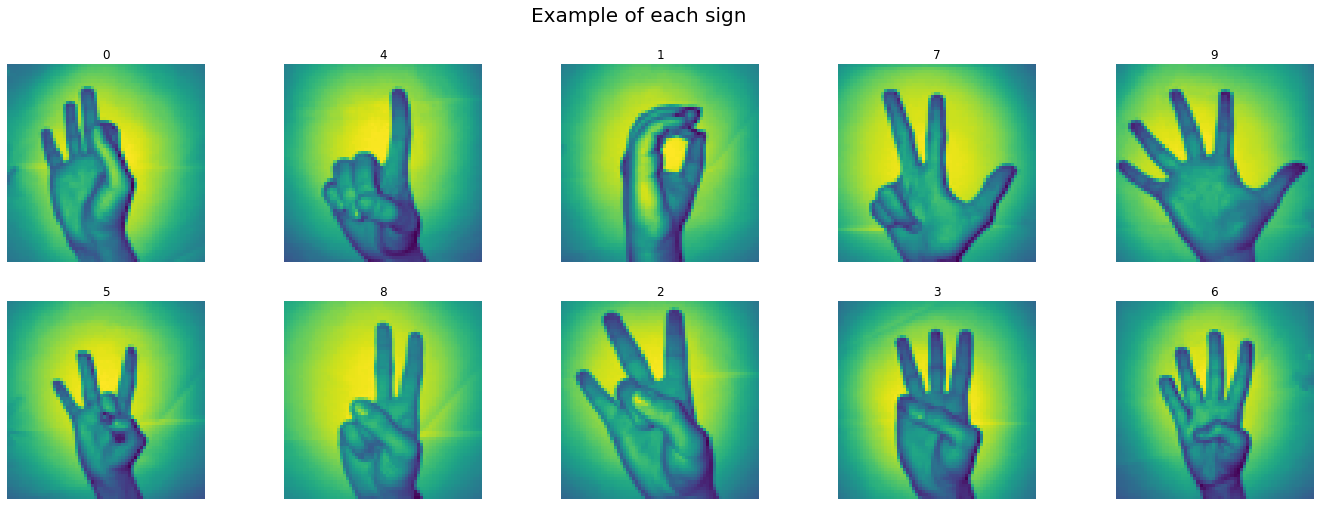

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(2,5,1)
plt.title(Y[0].argmax())
plt.imshow(X[0])
plt.axis("off")

plt.subplot(2,5,2)
plt.title(Y[1000].argmax())
plt.imshow(X[1000])
plt.axis("off")

plt.subplot(2,5,3)
plt.title(Y[222].argmax())
plt.imshow(X[222])
plt.axis("off")

plt.subplot(2,5,4)
plt.title(Y[1500].argmax())
plt.imshow(X[1500])
plt.axis("off")


plt.subplot(2,5,5)
plt.title(Y[2000].argmax())
plt.imshow(X[2000])
plt.axis("off")

plt.subplot(2,5,6)
plt.title(Y[1200].argmax())
plt.imshow(X[1200])
plt.axis("off")

plt.subplot(2,5,7)
plt.title(Y[1700].argmax())
plt.imshow(X[1700])
plt.axis("off")

plt.subplot(2,5,8)
plt.title(Y[500].argmax())
plt.imshow(X[500])
plt.axis("off")

plt.subplot(2,5,9)
plt.title(Y[700].argmax())
plt.imshow(X[700])
plt.axis("off")

plt.subplot(2,5,10)
plt.title(Y[1400].argmax())
plt.imshow(X[1400])
plt.axis("off")

plt.suptitle("Example of each sign", fontsize=20)
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = x_train.reshape(-1,64,64,1)
x_test = x_test.reshape(-1,64,64,1)

In [ ]:
input_shape = x_train.shape[1:] # (64, 64, 1) - channels last
number_of_classes = y_train.shape[1]
     
# parameters for cnn that do NOT have to be saved
maximum_epochs = 50
early_stop_epochs = 5
learning_rate_epochs = 3
batch_size = 128
max_kernel_size = 5
        
# parameters that change for each iteration that must be saved
list_early_stop_epochs = []
list_validation_loss = []

def CNN_function(num_cnn_blocks, num_filters):

    # Here, each cnn block consists of two Conv2D layers and one MaxPooling2D layer

    # variable parameters
    params = {'num_cnn_blocks':int(num_cnn_blocks),
                'num_filters':int(16*num_filters)}

    # start of cnn coding   
    input_tensor = Input(shape=input_shape)

    # 1st cnn block
    x = Conv2D(filters=params['num_filters'], kernel_size=max_kernel_size, strides=1, padding='same')(input_tensor)
    x = Conv2D(filters=params['num_filters']*2, kernel_size=max_kernel_size, strides=1, padding='same')(x)
    x = MaxPooling2D()(x)
    #x = Dropout(0.2)(x)

    # additional cnn blocks
    for iblock in range(params['num_cnn_blocks'] - 2):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=params['num_filters']*2, kernel_size=max_kernel_size-iblock-1, strides=1, padding='same')(x)
        x = Conv2D(filters=params['num_filters']*2, kernel_size=max_kernel_size-iblock-1, strides=1, padding='same')(x)
        x = MaxPooling2D()(x)
        x = Dropout(0.2)(x)

    # last cnn block
    x = Conv2D(filters=params['num_filters']*2, kernel_size=max_kernel_size-iblock-1, strides=1, padding='same')(x)                
    x = Conv2D(filters=params['num_filters'], kernel_size=max_kernel_size-iblock-1, strides=1, padding='same')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    # dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(40, activation='relu')(x)
    output_tensor = Dense(10, activation='softmax')(x)

    # instantiate and compile model
    cnn_model = Model(inputs=input_tensor, outputs=output_tensor)

    cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00025), metrics=['accuracy'])


    # callbacks for early stopping and for learning rate reducer
    callbacks_list = [EarlyStopping(monitor='val_loss', patience=early_stop_epochs, min_delta=0.05),                     
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                      patience=learning_rate_epochs, 
                                      verbose=0, mode='auto', min_lr=1.0e-6),
                    ModelCheckpoint(filepath="best_model.h5",
                                    monitor='val_loss', save_best_only=True)]

    # fit the model
    h = cnn_model.fit(x=x_train, y=y_train,
                    batch_size=batch_size,
                    epochs=maximum_epochs,
                    validation_split=0.25,
                    callbacks=callbacks_list)

    # record actual best epochs and valid loss here, added to bayes opt parameter df below
    list_early_stop_epochs.append(len(h.history['val_loss']) - early_stop_epochs)

    validation_loss = np.min(h.history['val_loss'])
    list_validation_loss.append(validation_loss)

    # bayes opt is a maximization algorithm, to minimize validation_loss, return 1-this
    bayes_opt_score = 1.0 - validation_loss

    return bayes_opt_score

  # end of cnn_function()

In [ ]:
total_number_of_iterations = 12
number_of_random_points = 10
number_of_iterations =  total_number_of_iterations - number_of_random_points

start_time_total = time.time()

optimizer = BayesianOptimization(f=CNN_function,
            pbounds={'num_cnn_blocks':(3, 5.001),
                      'num_filters':(1, 2.001)},
                      verbose=2)
  
optimizer.maximize(init_points=number_of_random_points, n_iter=number_of_iterations)
  
print('\nBest Result:', optimizer.max)
  
elapsed_time_total = (time.time()-start_time_total)/3600
print('\n\nTotal elapsed time =',elapsed_time_total,' hours')

|   iter    |  target   | num_cn... | num_fi... |
-------------------------------------------------
Epoch 1/50
10/10 [==============================] - 46s 5s/step - loss: 2.3571 - accuracy: 0.1149 - val_loss: 2.3040 - val_accuracy: 0.0920
Epoch 2/50
10/10 [==============================] - 47s 5s/step - loss: 2.2595 - accuracy: 0.1561 - val_loss: 2.3027 - val_accuracy: 0.0920
Epoch 3/50
10/10 [==============================] - 45s 5s/step - loss: 2.1544 - accuracy: 0.2694 - val_loss: 2.3000 - val_accuracy: 0.0969
Epoch 4/50
10/10 [==============================] - 45s 4s/step - loss: 1.9400 - accuracy: 0.3479 - val_loss: 2.2955 - val_accuracy: 0.0969
Epoch 5/50
10/10 [==============================] - 45s 4s/step - loss: 1.6251 - accuracy: 0.4312 - val_loss: 2.2775 - val_accuracy: 0.1985
Epoch 6/50
10/10 [==============================] - 45s 4s/step - loss: 1.3322 - accuracy: 0.5396 - val_loss: 2.2591 - val_accuracy: 0.1840
|  1        | -1.259    |  4.386    |  1.509    |
Epoch 1/50

In [ ]:
print('\nBest Result:', optimizer.max)


Best Result: {'target': 0.7485941350460052, 'params': {'num_cnn_blocks': 3.5757944695006136, 'num_filters': 1.3908697208103726}}


In [ ]:
model_final = load_model("best_model.h5")

In [ ]:
predicted_prob = model_final.predict(x_test)
y_predicted_class = np.argmax(predicted_prob, axis=1)

In [ ]:
y_true = np.argmax(y_test, axis=1)

Jaccard Score is used to calculate the accuracy of multiclass classification

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
jaccard_score(y_true, y_predicted_class, average=None)

array([0.90697674, 0.93877551, 0.86792453, 0.91428571, 0.88571429,
       0.80434783, 0.76086957, 1.        , 0.91304348, 0.93478261])

In [ ]:
y_predicted_class

array([6, 9, 3, 9, 0, 0, 8, 2, 5, 9, 4, 9, 7, 1, 3, 3, 0, 5, 0, 7, 0, 8,
       3, 1, 9, 2, 7, 3, 5, 9, 8, 5, 4, 6, 4, 6, 3, 1, 9, 2, 7, 7, 3, 1,
       1, 2, 0, 7, 8, 9, 1, 9, 6, 2, 1, 0, 6, 8, 2, 8, 2, 7, 2, 7, 5, 9,
       2, 3, 6, 4, 1, 1, 5, 7, 4, 9, 9, 4, 3, 8, 8, 9, 2, 0, 9, 0, 0, 4,
       1, 5, 5, 5, 7, 4, 7, 4, 2, 2, 8, 7, 2, 0, 9, 0, 2, 1, 7, 8, 8, 7,
       2, 8, 3, 3, 2, 2, 6, 1, 5, 5, 5, 0, 1, 5, 8, 2, 6, 5, 1, 0, 3, 1,
       9, 9, 8, 3, 8, 9, 2, 2, 2, 6, 2, 6, 6, 1, 5, 2, 5, 4, 9, 2, 1, 5,
       6, 2, 6, 6, 1, 1, 7, 5, 9, 8, 6, 2, 4, 7, 6, 9, 8, 7, 2, 9, 1, 6,
       7, 6, 0, 6, 1, 7, 4, 8, 4, 6, 5, 2, 4, 2, 8, 6, 8, 3, 2, 0, 8, 8,
       8, 5, 4, 7, 0, 8, 2, 4, 2, 5, 5, 8, 9, 0, 2, 8, 5, 3, 4, 3, 5, 0,
       5, 4, 6, 1, 7, 5, 4, 1, 6, 5, 8, 4, 7, 6, 2, 1, 5, 4, 6, 4, 9, 6,
       1, 0, 9, 0, 1, 2, 3, 9, 5, 4, 2, 0, 0, 4, 2, 5, 9, 2, 4, 7, 9, 8,
       3, 7, 3, 7, 7, 1, 1, 1, 4, 9, 5, 7, 7, 3, 1, 7, 5, 3, 6, 9, 1, 9,
       2, 9, 8, 3, 0, 7, 0, 8, 0, 6, 5, 8, 1, 0, 0,